In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
import pandas as pd
from global_model_periodic import LearnedSimulator_periodic
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

In [3]:
def voronoi_polygon_periodic(centers, target_indices):
    """
    Calcule les cellules de Voronoi uniquement pour les n_main premiers centres,
    entourés de duplications périodiques des autres.
    """
    init_square = torch.tensor([
        [-10.0, -10.0],
        [10.0, -10.0],
        [10.0, 10.0],
        [-10.0, 10.0],
    ], dtype=torch.float32, device=centers.device)

    vor_polygons = []

    for i in target_indices: 
        center = centers[i]
        polygon = init_square.clone()

        for j, neighbor in enumerate(centers):
            if i == j:
                continue
            midpoint = (center + neighbor) / 2
            direction = neighbor - center
            polygon = clip_polygon(polygon, midpoint, direction)
            if len(polygon) == 0:
                break

        if len(polygon) >= 3:
            vor_polygons.append(torch.stack(polygon))
        else:
            vor_polygons.append(torch.empty((0, 2), device=centers.device))

    return vor_polygons

def compute_half_plane(center, neighbor):
    """Retourne le vecteur normal et un point sur la bissectrice entre center et neighbor."""
    midpoint = (center + neighbor) / 2
    direction = neighbor - center
    return midpoint,direction

def clip_polygon(polygon, midpoint,original_direction):
    """Clippe un polygone avec un demi-plan défini par un point et une normale."""
    new_polygon = []
    prev_vertex = polygon[-1]
    prev_inside = torch.dot(prev_vertex - midpoint, original_direction) <= 0
    for curr_vertex in polygon:
        curr_inside = torch.dot(curr_vertex - midpoint, original_direction) <= 0
        if curr_inside:
            if not prev_inside:
                direction = curr_vertex - prev_vertex
                denom = torch.dot(direction, original_direction)
                if denom != 0:
                    t = torch.dot(midpoint - prev_vertex, original_direction) / denom
                    inter = prev_vertex + t * direction
                    new_polygon.append(inter)
            new_polygon.append(curr_vertex)
        elif prev_inside:
            direction = curr_vertex - prev_vertex
            denom = torch.dot(direction, original_direction)
            if denom != 0:
                t = torch.dot(midpoint - prev_vertex, original_direction) / denom
                inter = prev_vertex + t * direction
                new_polygon.append(inter)
        prev_vertex = curr_vertex
        prev_inside = curr_inside
    return new_polygon if len(new_polygon) >= 3 else []


def polygon_area(polygon):
        x = polygon[:, 0]
        y = polygon[:, 1]
        return 0.5 * torch.abs(torch.dot(x, torch.roll(y, -1)) - torch.dot(y, torch.roll(x, -1)))

def polygon_perimeter(polygon):
    return torch.sum(torch.norm(polygon - torch.roll(polygon, -1, dims=0), dim=1))

In [4]:
def voronoi_loss(output,target_indices,accelerations,target_areas= 0.4,masse = 0.1, dt = 0.05):
    vor_polygons = voronoi_polygon_periodic(output,target_indices)
    areas = []
    perimeters = []
    min_val = torch.tensor(1e-6, device=output.device)
    for poly in vor_polygons:
        if poly.shape[0] >= 3:
            areas.append(polygon_area(poly))
            perimeters.append(polygon_perimeter(poly))
        else:
            areas.append(min_val)
            perimeters.append(min_val)

    areas_tensor = torch.stack(areas)
    perimeters_tensor = torch.stack(perimeters)
    physics_loss = torch.sum(0.02*(target_areas - areas_tensor)**2 + 0.000*perimeters_tensor+1e-5*(target_areas/(areas_tensor))**2)
    kinetic_loss = torch.sum((0.5*masse*dt**2)*(accelerations/(dt**2))**2)
    return physics_loss+kinetic_loss

In [5]:
def loss_complete(acceleration, target,output,target_indices):
    physics_loss = voronoi_loss(output,target_indices,acceleration)
    return physics_loss

In [6]:
class TrajectoryDataset(Dataset):
    def __init__(self, csv_file_paths, step, seq_len=5, noise_std=0.0):
        self.samples = []
        self.seq_len = seq_len
        self.noise_std = noise_std

        for i in range(1,10):
            csvpath = csv_file_paths + str(i) + ".csv"
            df = pd.read_csv(
                csvpath,
                dtype={"x": np.float32, "y": np.float32, "step": np.int32, "site_index": np.int32}
            )
            

            df_grouped = df.groupby('step')
            clean_positions = []

            for step_id, data in df_grouped:
                if step_id < step:
                    data_sorted = data.sort_values('site_index')
                    np_data = data_sorted[['x', 'y']].to_numpy(dtype=np.float32)
                    pos = torch.from_numpy(np_data) 
                    clean_positions.append(pos)

            for t in range(seq_len - 1, len(clean_positions)):
                # séquence des N dernières positions
                input_seq = clean_positions[t - seq_len + 1: t + 1] 
                input_seq_tensor = torch.stack(input_seq)
                x_t2 = input_seq[-3]
                x_t1 = input_seq[-2]
                x_t = input_seq[-1]
                acc = x_t - 2 * x_t1 + x_t2
                def noisy(x): 
                    return x + torch.randn_like(x) * self.noise_std if self.noise_std > 0 else x

                input_seq_noisy = torch.stack([noisy(x) for x in input_seq])
                self.samples.append((input_seq_noisy, acc))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [7]:
def generate_next_positions(model, device, vrai_pos,n_cells):
    model.eval()
    pos = vrai_pos.copy()
    x = torch.tensor(np.stack(pos, axis=1), dtype=torch.float).to(device)
    next_position, acc = model(x,n_cells)
    for i in range(len(pos)-1):
        pos[i] = pos[i+1].copy()
    pos[-1] = next_position.cpu().detach().numpy()
    return pos,acc

In [8]:
def avg_test(model,device,csv_file,n_cells):
    loss = 0
    csvpath = csv_file + str(12) +".csv" 
    df = pd.read_csv(csvpath)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = loss_complete
    vrai_pos = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions)
        vrai_pos.append(positions)
    for step in steps_list[5:20]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
            vrai_pos[i] = vrai_pos[i+1].copy() 
        vrai_pos[-1] = positions.copy()
        loss+=loss_fn(acc,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float).to(device),torch.tensor(pos[-1], dtype=torch.float).to(device),np.arange(n_cells)).item()
    return loss/15
        

In [9]:
def train_gnn_optimized(model, csv_files, loss_fn, epochs=11, lr=1e-4, batch_size=32, seq_len=5, noise_std=0.0, device='cuda'):
    model = model.to(device)
    model = torch.compile(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    n_cells = 10
    print("Loading dataset...")
    start = time.perf_counter()
    dataset = TrajectoryDataset(csv_files, step=20, seq_len=seq_len, noise_std=noise_std)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Dataset loaded in {time.perf_counter() - start:.2f} seconds")
    
    model.train()
    train_loss = []
    test_loss = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_batches = 0
        for x_seq, acc in dataloader:
            x_seq = x_seq.to(device)
            acc = acc.to(device).squeeze(0)
            acc =acc[:n_cells]
            input_traj = x_seq.permute(0, 2, 1, 3).squeeze(0) 
            optimizer.zero_grad()
            with autocast(device_type='cuda',enabled=False):
                output, pred_acc = model(input_traj,n_cells)
                loss = loss_fn(pred_acc, acc, output,np.arange(n_cells))
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1

        avg_loss = total_loss / total_batches if total_batches > 0 else 0

        if epoch % 1== 0:
            model.eval()
            train_loss.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.6f}")
            test_l = avg_test(model, device, csv_files,n_cells)
            test_loss.append(test_l)
            print(f"Test Loss: {test_l:.6f}")
            model.train()
            print(acc,pred_acc)
            # Save model and loss
            path_prefix = "/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Unsupervised/Training/unsupervised_15Conv_256_voronoi/"
            torch.save(model.state_dict(), path_prefix + f"model_{epoch}.pth")
            loss_df = pd.DataFrame({
                "epoch": list(range(len(train_loss))),
                "global_loss": train_loss,
                "test_loss": test_loss
            })
            loss_df.to_csv(path_prefix + f"loss_{epoch}.csv", index=False)

    return model, train_loss, test_loss


In [10]:
normalization_stats = {
    "velocity": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)},
    "acceleration": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e0, 1e0]).to(device)}
}

In [11]:
model = LearnedSimulator_periodic(num_dimensions=2, normalization_stats=normalization_stats, device=device)
model.to(device)
trained_model, train_loss, test_loss = train_gnn_optimized(
    model=model,
    csv_files="/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_",
    loss_fn=loss_complete,
    epochs= 51,
    lr=1e-5,
    batch_size=1,
    seq_len=5,
    noise_std=0.0001,
    device='cuda'
)


Loading dataset...
Dataset loaded in 0.28 seconds


  0%|          | 0/51 [00:00<?, ?it/s]W0711 09:32:59.037000 458819 torch/_dynamo/convert_frame.py:964] [6/8] torch._dynamo hit config.recompile_limit (8)
W0711 09:32:59.037000 458819 torch/_dynamo/convert_frame.py:964] [6/8]    function: 'compute_polygon_area_and_perimeter' (/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Unsupervised/Model/global_model_periodic.py:34)
W0711 09:32:59.037000 458819 torch/_dynamo/convert_frame.py:964] [6/8]    last reason: 6/0: len(polygon) == 4                                      
W0711 09:32:59.037000 458819 torch/_dynamo/convert_frame.py:964] [6/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0711 09:32:59.037000 458819 torch/_dynamo/convert_frame.py:964] [6/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Epoch 1/51, Avg Loss: 0.163388


  2%|▏         | 1/51 [02:22<1:58:28, 142.17s/it]

Test Loss: 0.002838
tensor([[-5.0187e-05, -3.8326e-05],
        [ 1.9044e-04,  7.0930e-06],
        [-2.8014e-05,  4.5745e-05],
        [ 6.7413e-05,  5.8889e-05],
        [-8.7202e-05,  6.4969e-05],
        [-9.5814e-06, -1.0870e-05],
        [-1.0806e-04,  4.5598e-05],
        [-4.8995e-05, -3.3021e-05],
        [ 6.2164e-05, -9.4444e-05],
        [ 1.1861e-05, -4.5598e-05]], device='cuda:0') tensor([[-3.4176e-05,  1.0258e-04],
        [ 5.6624e-07,  5.4188e-05],
        [-5.1454e-05,  1.1580e-04],
        [-3.5979e-05,  9.5628e-05],
        [-5.1156e-05,  1.0977e-04],
        [-2.7936e-05,  9.5136e-05],
        [-4.5475e-05,  6.4455e-05],
        [-1.1640e-05,  8.6877e-05],
        [-2.0007e-05,  5.6915e-05],
        [-2.2337e-05,  1.0872e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 2/51, Avg Loss: 0.004327


  4%|▍         | 2/51 [04:35<1:52:01, 137.18s/it]

Test Loss: 0.002839
tensor([[-1.3679e-04, -1.5554e-04],
        [ 1.6743e-04, -7.4506e-06],
        [ 1.3053e-04, -3.7789e-05],
        [-2.5630e-05, -2.5272e-05],
        [ 1.6898e-04, -8.1845e-05],
        [ 8.9407e-06,  2.6366e-04],
        [ 6.4909e-05, -8.7470e-05],
        [-1.6707e-04,  5.0664e-07],
        [-2.1827e-04,  1.1271e-04],
        [ 7.0259e-06,  1.8597e-05]], device='cuda:0') tensor([[ 2.2465e-05, -1.0371e-04],
        [ 5.5807e-05, -9.2387e-06],
        [ 4.5018e-05, -4.6223e-05],
        [ 7.6201e-06, -1.0047e-05],
        [ 7.5053e-05, -1.9815e-05],
        [-6.8059e-05,  8.9686e-05],
        [ 5.9886e-05, -4.4361e-05],
        [-5.8150e-05,  5.8189e-06],
        [-1.0359e-04,  6.7137e-05],
        [-6.1151e-06,  8.1137e-06]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 3/51, Avg Loss: 0.004327


  6%|▌         | 3/51 [06:46<1:47:15, 134.08s/it]

Test Loss: 0.002838
tensor([[-9.0331e-05, -8.3119e-05],
        [ 1.2404e-04, -2.1234e-05],
        [-1.1092e-04, -1.3113e-05],
        [-6.8486e-05, -3.7730e-05],
        [ 2.7001e-05,  3.9518e-05],
        [ 7.2777e-05,  2.9802e-08],
        [ 1.1772e-06,  7.6592e-05],
        [-1.4323e-04,  1.4204e-04],
        [ 1.3387e-04,  3.6225e-05],
        [ 5.4181e-05, -1.3918e-04]], device='cuda:0') tensor([[ 3.5563e-05, -5.4166e-06],
        [ 4.3567e-05,  1.0297e-05],
        [ 3.4077e-05, -2.1391e-05],
        [ 6.4744e-05, -2.8960e-05],
        [ 4.1468e-05, -9.8571e-06],
        [ 4.4988e-05,  3.2291e-05],
        [ 1.6147e-05,  4.0274e-05],
        [ 2.1817e-05,  2.2117e-05],
        [ 5.8169e-05, -2.3454e-05],
        [ 7.2107e-05, -2.5220e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 4/51, Avg Loss: 0.004327


  8%|▊         | 4/51 [08:57<1:44:00, 132.77s/it]

Test Loss: 0.002838
tensor([[-8.9169e-05, -8.2009e-05],
        [ 1.2189e-04, -2.1636e-05],
        [-1.0630e-04, -1.2755e-05],
        [-6.7770e-05, -3.7596e-05],
        [ 2.3663e-05,  3.8475e-05],
        [ 7.0691e-05, -1.7583e-06],
        [ 1.2368e-06,  7.5519e-05],
        [-1.4073e-04,  1.3822e-04],
        [ 1.3298e-04,  3.7283e-05],
        [ 5.3644e-05, -1.3378e-04]], device='cuda:0') tensor([[ 4.6743e-05, -9.7349e-05],
        [ 4.3189e-05, -1.5303e-05],
        [ 1.5499e-05, -3.9615e-05],
        [ 3.5243e-05, -9.4384e-05],
        [ 2.9972e-05, -5.6215e-06],
        [ 5.2871e-05,  9.1530e-06],
        [ 1.5199e-06,  4.4033e-06],
        [-2.3125e-05, -2.5742e-05],
        [ 6.8812e-05, -4.4730e-05],
        [ 7.2312e-05, -8.7522e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 5/51, Avg Loss: 0.004327


 10%|▉         | 5/51 [11:06<1:40:53, 131.59s/it]

Test Loss: 0.002839
tensor([[ 5.8651e-05,  1.2845e-05],
        [-1.2839e-04,  8.2314e-05],
        [ 1.7306e-04,  2.8408e-04],
        [ 4.9055e-05, -2.1529e-04],
        [-9.9555e-05,  1.1209e-04],
        [-5.9366e-05, -6.1691e-05],
        [ 8.9258e-06, -1.2815e-04],
        [ 3.4094e-05, -1.2833e-04],
        [-8.7082e-05,  1.1331e-04],
        [ 5.0783e-05, -7.1168e-05]], device='cuda:0') tensor([[ 8.8358e-05, -5.5950e-05],
        [ 3.2837e-05, -4.3500e-05],
        [ 3.8512e-05, -1.2726e-05],
        [ 8.9899e-05, -9.0797e-05],
        [ 3.8017e-05, -4.1407e-05],
        [ 9.7360e-05, -9.7137e-05],
        [ 1.2499e-04, -1.1952e-04],
        [ 1.0918e-04, -1.3030e-04],
        [ 4.4344e-05, -3.7063e-05],
        [ 1.1963e-04, -1.1670e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 6/51, Avg Loss: 0.004326


 12%|█▏        | 6/51 [13:15<1:38:03, 130.75s/it]

Test Loss: 0.002838
tensor([[ 1.5378e-05, -1.3639e-04],
        [ 2.4438e-05,  5.1498e-05],
        [-3.5882e-05,  5.3108e-05],
        [-7.0840e-05, -7.7963e-05],
        [-3.3885e-05, -3.0758e-04],
        [ 2.0366e-05, -7.6324e-05],
        [ 5.5283e-05,  1.3006e-04],
        [ 9.3341e-05,  1.2839e-04],
        [-1.3262e-05,  1.6111e-04],
        [-5.4777e-05,  7.4163e-05]], device='cuda:0') tensor([[ 1.8047e-05, -4.9584e-05],
        [-3.0652e-05,  3.9387e-05],
        [-3.3457e-05,  6.3196e-05],
        [-3.0516e-05, -2.0675e-05],
        [-5.0301e-05,  3.1311e-05],
        [ 6.8847e-05, -8.7850e-05],
        [ 1.6525e-05,  2.3115e-05],
        [-3.8285e-05,  7.4282e-05],
        [-8.1453e-06,  2.3305e-05],
        [-8.7781e-05,  9.8571e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 7/51, Avg Loss: 0.004326


 14%|█▎        | 7/51 [15:27<1:36:09, 131.12s/it]

Test Loss: 0.002839
tensor([[-1.0437e-04, -1.2007e-04],
        [ 1.8317e-04, -1.8626e-05],
        [ 9.4712e-05, -8.6963e-05],
        [-1.9521e-05, -2.9743e-05],
        [ 1.7488e-04, -7.7955e-05],
        [ 1.7285e-06,  2.8974e-04],
        [ 6.6996e-05, -9.1255e-05],
        [-1.7267e-04, -6.7055e-08],
        [-2.3317e-04,  1.1528e-04],
        [ 8.2403e-06,  1.9759e-05]], device='cuda:0') tensor([[ 9.2831e-05, -1.3775e-04],
        [ 7.7125e-05, -7.3764e-05],
        [ 9.9465e-05, -9.2823e-05],
        [ 5.6071e-05, -8.2932e-05],
        [ 1.0901e-04, -9.9316e-05],
        [ 2.8405e-05, -2.1119e-05],
        [ 1.1528e-04, -1.2299e-04],
        [ 3.9466e-05, -7.1310e-05],
        [-5.1521e-06, -4.1794e-05],
        [ 5.0988e-05, -2.7087e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 8/51, Avg Loss: 0.004326


 16%|█▌        | 8/51 [17:39<1:34:04, 131.27s/it]

Test Loss: 0.002838
tensor([[ 6.8486e-05,  1.7315e-05],
        [-1.0920e-04,  8.7887e-05],
        [ 1.8039e-04,  2.5462e-04],
        [ 2.0862e-06, -1.7738e-04],
        [-1.0456e-04,  9.5427e-05],
        [-5.2035e-05, -5.8234e-05],
        [ 7.1581e-06, -1.2183e-04],
        [ 3.7551e-05, -1.2970e-04],
        [-7.8738e-05,  9.8586e-05],
        [ 4.8816e-05, -6.6578e-05]], device='cuda:0') tensor([[ 4.1252e-05, -3.7134e-05],
        [-3.4893e-05,  1.9960e-05],
        [-2.2188e-05,  1.1099e-04],
        [ 3.7340e-05, -5.9564e-05],
        [-4.1112e-05,  4.7430e-05],
        [ 5.3743e-05, -1.3117e-04],
        [ 6.4177e-05, -1.3884e-04],
        [ 5.6788e-05, -1.3877e-04],
        [-2.6478e-05,  3.9712e-06],
        [ 1.0516e-04, -1.3017e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 9/51, Avg Loss: 0.004326


 18%|█▊        | 9/51 [19:46<1:31:08, 130.20s/it]

Test Loss: 0.002838
tensor([[-4.7266e-05, -3.7253e-05],
        [ 1.7041e-04,  3.2067e-05],
        [-3.0160e-05,  5.3512e-05],
        [ 3.0458e-05,  3.8505e-05],
        [-8.6725e-05,  5.5075e-05],
        [-7.4506e-07, -1.5654e-05],
        [-4.5538e-05,  3.5107e-05],
        [-5.8234e-05, -3.2544e-05],
        [ 5.1688e-05, -9.2387e-05],
        [ 1.6332e-05, -3.6381e-05]], device='cuda:0') tensor([[ 3.5116e-05, -1.3971e-04],
        [ 1.0445e-04, -8.0023e-05],
        [-1.6611e-05, -2.8010e-05],
        [ 2.0098e-05, -2.9873e-05],
        [-4.2370e-05,  2.1089e-05],
        [ 4.1028e-05, -2.9985e-05],
        [-2.5120e-05,  6.3889e-06],
        [ 4.9692e-05, -1.3062e-04],
        [ 6.3097e-05, -1.2549e-04],
        [ 7.3139e-05, -9.9018e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 10/51, Avg Loss: 0.004326


 20%|█▉        | 10/51 [21:57<1:29:04, 130.36s/it]

Test Loss: 0.002838
tensor([[-9.2983e-06,  3.5216e-05],
        [-3.4273e-05, -2.2769e-05],
        [ 1.3885e-04, -9.0599e-05],
        [-6.6340e-05, -5.3674e-05],
        [ 1.0055e-04,  1.0282e-04],
        [ 8.6427e-06,  2.1823e-05],
        [-1.0240e-04, -1.0490e-05],
        [ 1.0008e-04,  1.1951e-05],
        [-1.2702e-04,  3.1345e-05],
        [-8.7917e-06, -2.5570e-05]], device='cuda:0') tensor([[-4.9040e-05,  8.7649e-05],
        [-5.1811e-05,  1.0974e-04],
        [-6.6329e-06,  4.5910e-05],
        [-6.1637e-05,  2.2803e-05],
        [-2.0104e-05,  1.1916e-04],
        [-5.0632e-05,  1.2406e-04],
        [-9.2916e-05,  7.3116e-05],
        [-2.3585e-05,  7.6868e-05],
        [-7.4927e-05,  7.7434e-05],
        [-5.5719e-05,  8.1699e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 11/51, Avg Loss: 0.004326


 22%|██▏       | 11/51 [24:09<1:27:07, 130.69s/it]

Test Loss: 0.002838
tensor([[-4.8757e-05, -3.8117e-05],
        [ 1.7935e-04,  2.2113e-05],
        [-2.9296e-05,  5.0927e-05],
        [ 4.5359e-05,  4.6551e-05],
        [-8.7082e-05,  5.9724e-05],
        [-4.5002e-06, -1.3612e-05],
        [-7.0632e-05,  4.0054e-05],
        [-5.5313e-05, -3.3259e-05],
        [ 5.6595e-05, -9.3639e-05],
        [ 1.4305e-05, -4.0632e-05]], device='cuda:0') tensor([[-4.2878e-06, -4.2472e-05],
        [ 6.5144e-05, -2.8450e-05],
        [-5.3246e-05,  2.8532e-05],
        [-2.3512e-05,  4.8351e-05],
        [-7.6089e-05,  6.4660e-05],
        [-8.7693e-06,  3.0253e-05],
        [-6.0968e-05,  1.9640e-05],
        [ 1.0854e-05, -7.8578e-05],
        [ 2.0869e-05, -8.2452e-05],
        [ 4.1723e-07, -2.1424e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 12/51, Avg Loss: 0.004326


 24%|██▎       | 12/51 [26:19<1:24:52, 130.59s/it]

Test Loss: 0.002838
tensor([[-8.8781e-05, -7.2487e-05],
        [ 1.1230e-04, -2.5213e-05],
        [-8.9437e-05, -1.1444e-05],
        [-6.5029e-05, -3.7044e-05],
        [ 1.1265e-05,  3.5405e-05],
        [ 6.2346e-05, -8.5980e-06],
        [ 5.5134e-07,  6.8963e-05],
        [-1.2469e-04,  1.2302e-04],
        [ 1.2958e-04,  4.1872e-05],
        [ 5.1856e-05, -1.1429e-04]], device='cuda:0') tensor([[-4.2118e-05, -9.1098e-05],
        [ 6.6612e-05, -7.2010e-06],
        [-6.5891e-05, -5.5324e-05],
        [-4.3761e-05, -3.4299e-05],
        [ 1.0613e-05,  2.8897e-05],
        [ 6.4598e-05,  1.1176e-08],
        [-3.2252e-05,  6.1784e-05],
        [-1.0006e-04,  1.1730e-04],
        [ 1.2062e-04, -1.6402e-05],
        [ 4.5674e-05, -9.9704e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 13/51, Avg Loss: 0.004325


 25%|██▌       | 13/51 [28:33<1:23:24, 131.70s/it]

Test Loss: 0.002838
tensor([[ 1.0729e-05,  1.0967e-04],
        [-1.0429e-04, -9.5665e-06],
        [ 5.8055e-05,  2.9668e-05],
        [ 7.7486e-05,  9.6679e-05],
        [-2.5183e-05, -1.2779e-04],
        [-3.3259e-05,  6.6340e-05],
        [ 6.6042e-05, -1.6668e-04],
        [-4.0114e-05, -7.7486e-07],
        [-4.7475e-05,  8.0764e-05],
        [ 3.7909e-05, -7.8231e-05]], device='cuda:0') tensor([[ 2.0742e-05,  7.9308e-05],
        [-2.8757e-05, -3.9093e-05],
        [ 7.7041e-05, -2.2851e-05],
        [ 6.2497e-05,  4.7892e-05],
        [ 4.3610e-05, -1.2421e-04],
        [-1.0224e-05,  5.5093e-05],
        [ 9.7195e-05, -1.3332e-04],
        [ 1.7455e-05,  2.9951e-06],
        [-3.9291e-05,  7.0602e-05],
        [ 6.4528e-05, -7.2971e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 14/51, Avg Loss: 0.004326


 27%|██▋       | 14/51 [30:45<1:21:09, 131.61s/it]

Test Loss: 0.002838
tensor([[-8.7649e-05, -8.0358e-05],
        [ 1.1909e-04, -2.2337e-05],
        [-1.0005e-04, -1.2219e-05],
        [-6.6876e-05, -3.7387e-05],
        [ 1.9073e-05,  3.7193e-05],
        [ 6.7592e-05, -4.2617e-06],
        [ 1.3113e-06,  7.3969e-05],
        [-1.3721e-04,  1.3298e-04],
        [ 1.3173e-04,  3.8862e-05],
        [ 5.2929e-05, -1.2645e-04]], device='cuda:0') tensor([[ 1.2852e-06, -1.2753e-04],
        [ 1.0761e-04, -2.8025e-05],
        [-2.9251e-05, -8.9280e-05],
        [-1.2834e-05, -9.6694e-05],
        [ 2.8916e-05, -1.2621e-05],
        [ 7.7587e-05, -2.5257e-05],
        [-1.0880e-05,  1.2245e-05],
        [-8.8394e-05,  3.0626e-05],
        [ 1.3569e-04, -2.6777e-05],
        [ 7.6991e-05, -1.4057e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 15/51, Avg Loss: 0.004325


 29%|██▉       | 15/51 [32:54<1:18:37, 131.04s/it]

Test Loss: 0.002838
tensor([[-9.6560e-06,  3.5642e-05],
        [-3.5107e-05, -2.2888e-05],
        [ 1.4096e-04, -9.2745e-05],
        [-6.6757e-05, -5.4270e-05],
        [ 1.0192e-04,  1.0490e-04],
        [ 9.0897e-06,  2.2046e-05],
        [-1.0389e-04, -1.0431e-05],
        [ 1.0127e-04,  1.1414e-05],
        [-1.2836e-04,  3.1747e-05],
        [-9.3579e-06, -2.5511e-05]], device='cuda:0') tensor([[-2.3575e-05,  3.5241e-05],
        [-6.5845e-06, -6.8210e-06],
        [ 4.7823e-05, -5.6654e-05],
        [-3.2814e-05, -5.8301e-05],
        [ 5.3210e-05,  3.7529e-05],
        [ 9.7807e-06,  4.3795e-05],
        [-5.0230e-05, -1.3001e-05],
        [ 1.7440e-05,  5.1484e-06],
        [-5.8459e-05, -1.8775e-05],
        [-2.0383e-05,  4.6045e-06]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 16/51, Avg Loss: 0.004325


 31%|███▏      | 16/51 [35:04<1:16:11, 130.61s/it]

Test Loss: 0.002838
tensor([[-7.9870e-06,  3.3723e-05],
        [-3.1292e-05, -2.2054e-05],
        [ 1.3176e-04, -8.3327e-05],
        [-6.5029e-05, -5.1737e-05],
        [ 9.5785e-05,  9.5665e-05],
        [ 6.7949e-06,  2.0832e-05],
        [-9.7394e-05, -1.0610e-05],
        [ 9.6500e-05,  1.3590e-05],
        [-1.2243e-04,  2.9907e-05],
        [-6.4969e-06, -2.5988e-05]], device='cuda:0') tensor([[ 1.7164e-05,  2.1640e-05],
        [ 3.1067e-05, -3.8713e-05],
        [ 1.1223e-04, -6.4477e-05],
        [-1.1334e-05, -9.6940e-05],
        [ 1.1926e-04,  4.1991e-05],
        [ 5.7379e-05,  3.1650e-05],
        [-1.5981e-05, -4.7095e-05],
        [ 8.7934e-05,  6.7428e-07],
        [-4.2634e-05, -2.1920e-05],
        [ 2.8268e-05, -1.0274e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 17/51, Avg Loss: 0.004325


 33%|███▎      | 17/51 [37:20<1:14:59, 132.35s/it]

Test Loss: 0.002838
tensor([[ 1.3430e-04, -2.4050e-05],
        [-6.3216e-05, -2.8551e-05],
        [-1.7762e-05,  5.7161e-05],
        [-1.2231e-04,  1.1919e-04],
        [ 2.1875e-05,  1.1241e-04],
        [ 8.4698e-05, -2.3961e-05],
        [ 1.7941e-05, -1.0216e-04],
        [-7.4506e-05, -1.1349e-04],
        [ 9.1165e-05,  5.2452e-06],
        [-7.2181e-05, -1.8626e-06]], device='cuda:0') tensor([[ 5.0666e-05,  2.8387e-06],
        [-1.0050e-04, -2.8517e-05],
        [-1.2668e-04,  1.1975e-04],
        [-1.7766e-04,  1.9392e-04],
        [-2.4656e-05,  1.4457e-04],
        [ 8.1228e-05, -6.6347e-06],
        [ 3.4356e-05, -1.2270e-04],
        [-8.3221e-05, -9.7446e-05],
        [ 1.1384e-04, -9.0152e-07],
        [-1.3142e-04,  3.9525e-06]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 18/51, Avg Loss: 0.004325


 35%|███▌      | 18/51 [39:34<1:13:03, 132.85s/it]

Test Loss: 0.002838
tensor([[-1.3804e-04, -1.7336e-04],
        [ 1.3733e-04,  2.7984e-05],
        [ 1.3232e-04,  2.9743e-05],
        [-2.5392e-05, -1.7166e-05],
        [ 1.5458e-04, -8.6434e-05],
        [ 1.1861e-05,  1.9014e-04],
        [ 5.8532e-05, -8.3506e-05],
        [-1.5408e-04, -5.9605e-07],
        [-1.8191e-04,  9.6858e-05],
        [ 4.8205e-06,  1.6421e-05]], device='cuda:0') tensor([[-1.3266e-04, -7.0591e-05],
        [ 1.1259e-04,  2.4356e-05],
        [ 6.0769e-05, -3.5204e-06],
        [-5.1470e-05,  8.4229e-06],
        [ 1.0969e-04, -3.5740e-05],
        [-7.7963e-05,  2.4815e-04],
        [ 3.7158e-05, -7.2177e-05],
        [-2.0385e-04,  6.4187e-05],
        [-2.1092e-04,  1.7748e-04],
        [-4.4504e-05,  8.9191e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 19/51, Avg Loss: 0.004325


 37%|███▋      | 19/51 [41:45<1:10:27, 132.10s/it]

Test Loss: 0.002837
tensor([[ 1.3609e-04, -1.9446e-05],
        [-6.4277e-05, -3.1412e-05],
        [-1.8895e-05,  5.7042e-05],
        [-1.2644e-04,  1.2034e-04],
        [ 2.6643e-05,  1.1978e-04],
        [ 8.6606e-05, -2.4796e-05],
        [ 2.0564e-05, -1.0622e-04],
        [-7.7665e-05, -1.1724e-04],
        [ 9.3937e-05,  2.9802e-06],
        [-7.6473e-05, -1.1474e-06]], device='cuda:0') tensor([[ 9.5442e-05, -2.7828e-06],
        [-4.6074e-05, -3.8307e-05],
        [-5.6634e-05,  9.6150e-05],
        [-1.2870e-04,  1.7792e-04],
        [ 3.1855e-05,  1.4421e-04],
        [ 1.3992e-04, -3.0730e-05],
        [ 7.9280e-05, -1.1792e-04],
        [-2.7027e-05, -1.1361e-04],
        [ 1.6305e-04,  1.4085e-05],
        [-8.6021e-05,  1.7155e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 20/51, Avg Loss: 0.004325


 39%|███▉      | 20/51 [44:02<1:08:59, 133.54s/it]

Test Loss: 0.002838
tensor([[-1.0252e-05,  3.6382e-05],
        [-3.6716e-05, -2.3186e-05],
        [ 1.4466e-04, -9.6202e-05],
        [-6.7413e-05, -5.5283e-05],
        [ 1.0425e-04,  1.0854e-04],
        [ 1.0014e-05,  2.2411e-05],
        [-1.0657e-04, -1.0371e-05],
        [ 1.0300e-04,  1.0490e-05],
        [-1.3056e-04,  3.2432e-05],
        [-1.0431e-05, -2.5392e-05]], device='cuda:0') tensor([[-4.7015e-05,  4.8645e-05],
        [-4.8272e-05,  4.5158e-05],
        [ 1.9569e-05, -2.8033e-05],
        [-6.3760e-05, -1.9707e-06],
        [ 3.1527e-05,  7.6834e-05],
        [-1.3841e-05,  6.1240e-05],
        [-7.7898e-05,  2.1361e-05],
        [ 7.1824e-06,  4.6436e-05],
        [-7.2541e-05,  3.7175e-05],
        [-4.2301e-05,  3.6020e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 21/51, Avg Loss: 0.004325


 41%|████      | 21/51 [46:12<1:06:14, 132.50s/it]

Test Loss: 0.002838
tensor([[-3.9935e-06,  2.9260e-05],
        [-2.3246e-05, -1.9372e-05],
        [ 1.1191e-04, -5.9068e-05],
        [-6.0678e-05, -4.5836e-05],
        [ 8.0287e-05,  7.4685e-05],
        [ 1.2219e-06,  1.6145e-05],
        [-8.3923e-05, -1.1086e-05],
        [ 8.5831e-05,  1.7077e-05],
        [-1.0818e-04,  2.5168e-05],
        [ 1.0431e-06, -2.6882e-05]], device='cuda:0') tensor([[ 1.1040e-05,  4.8913e-06],
        [ 5.2005e-06, -5.3875e-05],
        [ 9.0940e-05, -6.4913e-05],
        [-7.5689e-05, -1.3511e-04],
        [ 1.2944e-04,  7.8503e-05],
        [ 3.9291e-05,  2.0921e-05],
        [-6.4071e-05, -5.6975e-05],
        [ 1.2939e-04,  5.9977e-07],
        [-8.6576e-05, -5.8487e-07],
        [ 4.4778e-06, -6.6970e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 22/51, Avg Loss: 0.004325


 43%|████▎     | 22/51 [48:22<1:03:45, 131.93s/it]

Test Loss: 0.002838
tensor([[ 7.9870e-06,  1.0407e-04],
        [-9.7811e-05, -9.7752e-06],
        [ 5.1141e-05,  2.7239e-05],
        [ 7.4446e-05,  9.5069e-05],
        [-2.4617e-05, -1.2221e-04],
        [-3.1620e-05,  6.0499e-05],
        [ 6.4731e-05, -1.6034e-04],
        [-4.0203e-05, -7.1526e-07],
        [-4.3541e-05,  7.6592e-05],
        [ 3.9577e-05, -7.0542e-05]], device='cuda:0') tensor([[ 7.5357e-05,  1.2401e-04],
        [-4.5221e-05, -4.0133e-05],
        [ 1.6030e-04,  1.1902e-05],
        [ 1.4398e-04,  8.1200e-05],
        [ 3.5180e-05, -1.4840e-04],
        [-1.8913e-05,  8.0522e-05],
        [ 1.1350e-04, -1.9383e-04],
        [ 4.7291e-05, -2.5716e-05],
        [-3.8018e-05,  1.0632e-04],
        [ 9.5824e-05, -1.1063e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 23/51, Avg Loss: 0.004325


 45%|████▌     | 23/51 [50:31<1:01:09, 131.05s/it]

Test Loss: 0.002837
tensor([[-8.7649e-05, -8.0358e-05],
        [ 1.1909e-04, -2.2337e-05],
        [-1.0005e-04, -1.2219e-05],
        [-6.6876e-05, -3.7387e-05],
        [ 1.9073e-05,  3.7193e-05],
        [ 6.7592e-05, -4.2617e-06],
        [ 1.3113e-06,  7.3969e-05],
        [-1.3721e-04,  1.3298e-04],
        [ 1.3173e-04,  3.8862e-05],
        [ 5.2929e-05, -1.2645e-04]], device='cuda:0') tensor([[-6.7301e-05, -1.0188e-04],
        [ 1.0001e-04,  7.1786e-06],
        [-9.5315e-05, -5.2463e-05],
        [-8.6997e-05, -6.5822e-05],
        [ 2.3991e-06,  3.1438e-05],
        [ 5.9379e-05,  1.1191e-05],
        [-4.0777e-05,  5.5697e-05],
        [-1.4410e-04,  8.3122e-05],
        [ 1.3477e-04,  2.7891e-05],
        [ 2.9266e-05, -1.1506e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 24/51, Avg Loss: 0.004325


 47%|████▋     | 24/51 [52:45<59:19, 131.84s/it]  

Test Loss: 0.002838
tensor([[ 1.3527e-04, -2.1726e-05],
        [-6.3761e-05, -2.9981e-05],
        [-1.8477e-05,  5.7101e-05],
        [-1.2442e-04,  1.1978e-04],
        [ 2.4319e-05,  1.1626e-04],
        [ 8.5652e-05, -2.4319e-05],
        [ 1.9312e-05, -1.0431e-04],
        [-7.6115e-05, -1.1528e-04],
        [ 9.2596e-05,  4.1723e-06],
        [-7.4446e-05, -1.5199e-06]], device='cuda:0') tensor([[ 1.2203e-04, -2.5008e-05],
        [-5.2346e-05, -6.4053e-05],
        [-4.9682e-05,  9.4321e-05],
        [-1.2398e-04,  1.5687e-04],
        [ 6.4546e-05,  1.3642e-04],
        [ 1.3977e-04, -4.0505e-05],
        [ 6.8856e-05, -1.7291e-04],
        [-5.3683e-05, -1.6143e-04],
        [ 1.7821e-04, -9.5256e-06],
        [-8.6496e-05, -2.6394e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 25/51, Avg Loss: 0.004325


 49%|████▉     | 25/51 [54:58<57:16, 132.18s/it]

Test Loss: 0.002837
tensor([[-4.9293e-05, -3.8326e-05],
        [ 1.8311e-04,  1.7226e-05],
        [-2.8849e-05,  4.9407e-05],
        [ 5.2452e-05,  5.0485e-05],
        [-8.7142e-05,  6.1572e-05],
        [-6.2138e-06, -1.2696e-05],
        [-8.2612e-05,  4.2021e-05],
        [-5.3465e-05, -3.3319e-05],
        [ 5.8569e-05, -9.3997e-05],
        [ 1.3411e-05, -4.2386e-05]], device='cuda:0') tensor([[ 1.4361e-06, -4.0751e-05],
        [ 1.3956e-04, -1.8291e-06],
        [-1.9986e-06,  1.8116e-05],
        [ 4.5016e-05,  5.0217e-05],
        [-2.5991e-05,  4.9420e-05],
        [ 3.9449e-05, -1.3556e-05],
        [-5.0917e-05,  5.0090e-05],
        [ 4.9360e-06, -4.8950e-05],
        [ 6.1277e-05, -9.5375e-05],
        [ 4.2576e-05, -3.0801e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 26/51, Avg Loss: 0.004325


 51%|█████     | 26/51 [57:11<55:09, 132.38s/it]

Test Loss: 0.002838
tensor([[-1.2904e-04, -1.4591e-04],
        [ 1.7142e-04, -1.2249e-05],
        [ 1.2171e-04, -5.0843e-05],
        [-2.4050e-05, -2.6524e-05],
        [ 1.7035e-04, -8.1055e-05],
        [ 7.9274e-06,  2.7281e-04],
        [ 6.5386e-05, -8.8081e-05],
        [-1.6832e-04,  4.3958e-07],
        [-2.2268e-04,  1.1259e-04],
        [ 7.3016e-06,  1.8805e-05]], device='cuda:0') tensor([[-1.5726e-05, -2.1785e-04],
        [ 1.8114e-04, -6.5804e-05],
        [ 1.1134e-04, -1.3045e-04],
        [ 3.5498e-05, -6.0640e-05],
        [ 1.7673e-04, -1.1870e-04],
        [ 4.7505e-05,  1.0334e-04],
        [ 1.1767e-04, -1.6023e-04],
        [-1.0220e-04, -7.2207e-05],
        [-1.1617e-04,  2.7865e-05],
        [ 4.0578e-05, -2.5254e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 27/51, Avg Loss: 0.004325


 53%|█████▎    | 27/51 [59:23<52:59, 132.46s/it]

Test Loss: 0.002837
tensor([[-8.8215e-05, -8.0969e-05],
        [ 1.2010e-04, -2.2084e-05],
        [-1.0228e-04, -1.2398e-05],
        [-6.7174e-05, -3.7491e-05],
        [ 2.0802e-05,  3.7700e-05],
        [ 6.8724e-05, -3.3826e-06],
        [ 1.2964e-06,  7.4565e-05],
        [-1.3840e-04,  1.3494e-04],
        [ 1.3214e-04,  3.8251e-05],
        [ 5.3167e-05, -1.2910e-04]], device='cuda:0') tensor([[-4.6320e-05, -1.1205e-04],
        [ 1.1174e-04, -7.3910e-06],
        [-4.9846e-05, -4.7751e-05],
        [-6.3546e-05, -1.0785e-04],
        [ 4.0319e-05,  9.9055e-06],
        [ 7.1118e-05, -1.0286e-05],
        [-1.5460e-06,  3.4474e-05],
        [-9.5475e-05,  6.0096e-05],
        [ 1.5332e-04,  5.9456e-06],
        [ 5.3206e-05, -1.2937e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 28/51, Avg Loss: 0.004325


 55%|█████▍    | 28/51 [1:01:40<51:16, 133.75s/it]

Test Loss: 0.002837
tensor([[-9.6560e-06,  3.5642e-05],
        [-3.5107e-05, -2.2888e-05],
        [ 1.4096e-04, -9.2745e-05],
        [-6.6757e-05, -5.4270e-05],
        [ 1.0192e-04,  1.0490e-04],
        [ 9.0897e-06,  2.2046e-05],
        [-1.0389e-04, -1.0431e-05],
        [ 1.0127e-04,  1.1414e-05],
        [-1.2836e-04,  3.1747e-05],
        [-9.3579e-06, -2.5511e-05]], device='cuda:0') tensor([[-2.2247e-05,  9.9376e-05],
        [-1.2878e-05,  4.1988e-05],
        [ 6.6351e-05, -2.0117e-06],
        [-5.5915e-05,  7.4506e-07],
        [ 8.9973e-05,  1.2456e-04],
        [ 2.3987e-05,  9.8757e-05],
        [-7.4344e-05,  4.7307e-05],
        [ 3.9058e-05,  7.3355e-05],
        [-8.1928e-05,  4.8377e-05],
        [-2.3877e-05,  5.6740e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 29/51, Avg Loss: 0.004325


 57%|█████▋    | 29/51 [1:04:03<50:01, 136.42s/it]

Test Loss: 0.002838
tensor([[ 3.8624e-05, -1.1109e-04],
        [ 1.3292e-05,  5.0962e-05],
        [-4.9412e-05,  5.9366e-05],
        [-6.5297e-05, -1.0139e-04],
        [-4.1723e-07, -2.3339e-04],
        [ 3.5618e-05, -5.8427e-05],
        [-4.3213e-06,  8.2523e-05],
        [ 9.0301e-05,  1.1629e-04],
        [-1.9491e-05,  1.4877e-04],
        [-3.8862e-05,  4.6402e-05]], device='cuda:0') tensor([[ 3.8072e-06, -9.2432e-05],
        [ 3.8842e-05,  1.1551e-04],
        [-1.3214e-05,  1.2251e-04],
        [-5.8932e-05, -7.7579e-05],
        [-4.0270e-05, -1.2917e-04],
        [ 6.6893e-05, -9.2804e-05],
        [ 1.0203e-04,  1.2469e-04],
        [ 8.7885e-05,  1.5824e-04],
        [ 2.4343e-05,  1.7394e-04],
        [-5.8806e-05,  1.2895e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 30/51, Avg Loss: 0.004325


 59%|█████▉    | 30/51 [1:06:24<48:15, 137.88s/it]

Test Loss: 0.002838
tensor([[-4.9531e-05, -3.8385e-05],
        [ 1.8495e-04,  1.4961e-05],
        [-2.8670e-05,  4.8630e-05],
        [ 5.5730e-05,  5.2392e-05],
        [-8.7142e-05,  6.2525e-05],
        [-7.0035e-06, -1.2271e-05],
        [-8.8334e-05,  4.2796e-05],
        [-5.2512e-05, -3.3319e-05],
        [ 5.9441e-05, -9.4175e-05],
        [ 1.2994e-05, -4.3161e-05]], device='cuda:0') tensor([[ 1.0528e-05, -8.5324e-05],
        [ 1.5290e-04, -2.2601e-05],
        [ 1.4793e-05,  5.1260e-06],
        [ 6.7750e-05,  1.7896e-05],
        [-1.5799e-05,  4.8850e-05],
        [ 5.9307e-05, -5.2452e-06],
        [-2.6910e-05,  1.4935e-05],
        [ 3.1548e-05, -8.0127e-05],
        [ 7.4163e-05, -1.0677e-04],
        [ 5.9305e-05, -5.9366e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 31/51, Avg Loss: 0.004325


 61%|██████    | 31/51 [1:08:43<46:01, 138.09s/it]

Test Loss: 0.002838
tensor([[-1.0252e-05,  3.6382e-05],
        [-3.6716e-05, -2.3186e-05],
        [ 1.4466e-04, -9.6202e-05],
        [-6.7413e-05, -5.5283e-05],
        [ 1.0425e-04,  1.0854e-04],
        [ 1.0014e-05,  2.2411e-05],
        [-1.0657e-04, -1.0371e-05],
        [ 1.0300e-04,  1.0490e-05],
        [-1.3056e-04,  3.2432e-05],
        [-1.0431e-05, -2.5392e-05]], device='cuda:0') tensor([[-3.1011e-05,  3.1326e-05],
        [-4.1816e-05,  2.0087e-05],
        [ 4.0334e-05, -4.7166e-05],
        [-5.9061e-05, -2.2657e-05],
        [ 5.7984e-05,  7.3116e-05],
        [ 3.8370e-07,  3.6713e-05],
        [-7.8049e-05,  5.2825e-06],
        [ 3.1304e-05,  2.5075e-05],
        [-7.0393e-05,  2.3652e-05],
        [-2.9407e-05,  1.4015e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 32/51, Avg Loss: 0.004325


 63%|██████▎   | 32/51 [1:11:05<44:06, 139.31s/it]

Test Loss: 0.002839
tensor([[-4.8459e-05, -3.7998e-05],
        [ 1.7732e-04,  2.4557e-05],
        [-2.9474e-05,  5.1647e-05],
        [ 4.1664e-05,  4.4584e-05],
        [-8.7023e-05,  5.8711e-05],
        [-3.6210e-06, -1.4119e-05],
        [-6.4433e-05,  3.8803e-05],
        [-5.6148e-05, -3.3081e-05],
        [ 5.5481e-05, -9.3460e-05],
        [ 1.4722e-05, -3.9659e-05]], device='cuda:0') tensor([[-1.4588e-04,  3.5036e-05],
        [ 2.0109e-05,  9.7949e-05],
        [-1.5741e-04,  1.5529e-04],
        [-7.7385e-05,  1.5686e-04],
        [-2.0239e-04,  1.9554e-04],
        [-1.0191e-04,  1.1846e-04],
        [-2.2577e-04,  1.6652e-04],
        [-1.4059e-04,  3.4504e-05],
        [-7.9533e-05,  7.9274e-06],
        [-8.4084e-05,  3.6713e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 33/51, Avg Loss: 0.004325


 65%|██████▍   | 33/51 [1:13:28<42:09, 140.55s/it]

Test Loss: 0.002837
tensor([[-4.8459e-05, -3.7998e-05],
        [ 1.7732e-04,  2.4557e-05],
        [-2.9474e-05,  5.1647e-05],
        [ 4.1664e-05,  4.4584e-05],
        [-8.7023e-05,  5.8711e-05],
        [-3.6210e-06, -1.4119e-05],
        [-6.4433e-05,  3.8803e-05],
        [-5.6148e-05, -3.3081e-05],
        [ 5.5481e-05, -9.3460e-05],
        [ 1.4722e-05, -3.9659e-05]], device='cuda:0') tensor([[-1.4845e-05, -5.1089e-05],
        [ 1.5497e-04,  1.4096e-05],
        [-2.5008e-05,  7.0855e-05],
        [ 5.6289e-05,  7.2137e-05],
        [-7.0866e-05,  1.1137e-04],
        [ 3.0296e-05,  3.2723e-05],
        [-9.4365e-05,  8.2277e-05],
        [-9.1121e-06, -5.0388e-05],
        [ 5.4665e-05, -7.7445e-05],
        [ 4.8699e-05, -4.9472e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 34/51, Avg Loss: 0.004324


 67%|██████▋   | 34/51 [1:15:48<39:42, 140.17s/it]

Test Loss: 0.002837
tensor([[ 6.3777e-06,  1.0085e-04],
        [-9.4183e-05, -9.8795e-06],
        [ 4.7326e-05,  2.5779e-05],
        [ 7.2718e-05,  9.3997e-05],
        [-2.4140e-05, -1.1885e-04],
        [-3.0607e-05,  5.7280e-05],
        [ 6.3896e-05, -1.5655e-04],
        [-4.0323e-05, -5.9605e-07],
        [-4.1276e-05,  7.4267e-05],
        [ 4.0472e-05, -6.6161e-05]], device='cuda:0') tensor([[ 3.0767e-05,  1.1861e-04],
        [-1.1453e-04, -5.9649e-05],
        [ 9.2827e-05,  2.5574e-05],
        [ 1.0937e-04,  9.2905e-05],
        [-3.1304e-05, -1.7215e-04],
        [-6.2961e-05,  1.1583e-04],
        [ 2.5727e-05, -1.8401e-04],
        [-4.4093e-05, -2.5626e-05],
        [-8.5529e-05,  9.5285e-05],
        [ 3.7536e-05, -1.2425e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 35/51, Avg Loss: 0.004325


 69%|██████▊   | 35/51 [1:18:06<37:16, 139.76s/it]

Test Loss: 0.002837
tensor([[-1.2147e-04, -1.3763e-04],
        [ 1.7518e-04, -1.6838e-05],
        [ 1.1361e-04, -6.2466e-05],
        [-2.2620e-05, -2.7657e-05],
        [ 1.7157e-04, -8.0287e-05],
        [ 7.1526e-06,  2.8172e-04],
        [ 6.5684e-05, -8.8766e-05],
        [-1.6958e-04,  3.4273e-07],
        [-2.2715e-04,  1.1247e-04],
        [ 7.5474e-06,  1.9133e-05]], device='cuda:0') tensor([[-5.8338e-05, -9.6247e-05],
        [ 1.3357e-04,  5.2374e-05],
        [ 8.1748e-05, -2.8890e-05],
        [-1.4119e-05,  3.4649e-05],
        [ 1.3096e-04, -4.7758e-06],
        [ 3.2280e-05,  2.0526e-04],
        [ 8.4378e-05, -4.6894e-05],
        [-1.1255e-04,  2.2650e-05],
        [-1.2921e-04,  1.1215e-04],
        [ 5.2825e-06,  8.4896e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 36/51, Avg Loss: 0.004325


 71%|███████   | 36/51 [1:20:24<34:48, 139.26s/it]

Test Loss: 0.002837
tensor([[-8.9586e-05, -8.2437e-05],
        [ 1.2285e-04, -2.1487e-05],
        [-1.0809e-04, -1.2875e-05],
        [-6.8128e-05, -3.7640e-05],
        [ 2.4855e-05,  3.8892e-05],
        [ 7.1347e-05, -1.1027e-06],
        [ 1.2070e-06,  7.5936e-05],
        [-1.4168e-04,  1.3971e-04],
        [ 1.3328e-04,  3.6880e-05],
        [ 5.3823e-05, -1.3579e-04]], device='cuda:0') tensor([[-5.6505e-05, -4.7795e-05],
        [ 5.9914e-05, -2.4565e-05],
        [-8.4985e-05, -1.3921e-05],
        [-7.7637e-05, -4.5769e-05],
        [ 1.6443e-05,  3.0711e-05],
        [ 4.6287e-05, -3.7253e-08],
        [-1.6615e-05,  3.6098e-05],
        [-1.2632e-04,  8.7254e-05],
        [ 9.8154e-05,  1.3262e-06],
        [ 2.0159e-05, -1.0262e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 37/51, Avg Loss: 0.004325


 73%|███████▎  | 37/51 [1:22:40<32:13, 138.12s/it]

Test Loss: 0.002838
tensor([[-9.2983e-06,  3.5216e-05],
        [-3.4273e-05, -2.2769e-05],
        [ 1.3885e-04, -9.0599e-05],
        [-6.6340e-05, -5.3674e-05],
        [ 1.0055e-04,  1.0282e-04],
        [ 8.6427e-06,  2.1823e-05],
        [-1.0240e-04, -1.0490e-05],
        [ 1.0008e-04,  1.1951e-05],
        [-1.2702e-04,  3.1345e-05],
        [-8.7917e-06, -2.5570e-05]], device='cuda:0') tensor([[ 2.9113e-06,  1.4015e-05],
        [-1.9800e-05, -1.4123e-05],
        [ 8.0368e-05, -6.8314e-05],
        [-5.9092e-05, -8.0183e-05],
        [ 9.0500e-05,  7.6298e-05],
        [ 1.1945e-05,  1.5870e-05],
        [-9.7159e-05, -2.4326e-05],
        [ 7.9321e-05, -6.6943e-06],
        [-7.2425e-05,  4.2468e-07],
        [-1.3599e-05, -2.8577e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 38/51, Avg Loss: 0.004325


 75%|███████▍  | 38/51 [1:24:56<29:48, 137.55s/it]

Test Loss: 0.002837
tensor([[ 6.3777e-06,  1.0085e-04],
        [-9.4183e-05, -9.8795e-06],
        [ 4.7326e-05,  2.5779e-05],
        [ 7.2718e-05,  9.3997e-05],
        [-2.4140e-05, -1.1885e-04],
        [-3.0607e-05,  5.7280e-05],
        [ 6.3896e-05, -1.5655e-04],
        [-4.0323e-05, -5.9605e-07],
        [-4.1276e-05,  7.4267e-05],
        [ 4.0472e-05, -6.6161e-05]], device='cuda:0') tensor([[ 4.0315e-05,  9.8240e-05],
        [-1.0456e-04, -8.0038e-05],
        [ 1.0546e-04,  1.0341e-05],
        [ 1.2091e-04,  7.5061e-05],
        [-1.9182e-05, -1.9309e-04],
        [-5.1878e-05,  9.6742e-05],
        [ 3.6795e-05, -2.0054e-04],
        [-3.3872e-05, -4.3172e-05],
        [-7.1947e-05,  7.5575e-05],
        [ 5.1882e-05, -1.4316e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 39/51, Avg Loss: 0.004324


 76%|███████▋  | 39/51 [1:27:14<27:30, 137.57s/it]

Test Loss: 0.002837
tensor([[-9.0063e-05, -6.5230e-05],
        [ 1.0633e-04, -2.8059e-05],
        [-8.0287e-05, -1.0967e-05],
        [-6.3300e-05, -3.6806e-05],
        [ 4.4107e-06,  3.3915e-05],
        [ 5.7757e-05, -1.2562e-05],
        [-2.9802e-07,  6.4135e-05],
        [-1.1325e-04,  1.1444e-04],
        [ 1.2767e-04,  4.5002e-05],
        [ 5.0902e-05, -1.0382e-04]], device='cuda:0') tensor([[-6.8558e-05, -1.5684e-04],
        [ 1.8172e-04, -4.4562e-05],
        [-1.0640e-04, -7.6823e-05],
        [-6.2818e-05, -1.3206e-04],
        [ 8.2403e-05,  3.2220e-05],
        [ 1.5039e-04, -3.1587e-05],
        [ 3.0018e-05,  6.5662e-05],
        [-7.7024e-05,  1.1047e-04],
        [ 2.2192e-04, -3.9153e-06],
        [ 6.4272e-05, -1.7586e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 40/51, Avg Loss: 0.004325


 78%|███████▊  | 40/51 [1:29:28<25:03, 136.68s/it]

Test Loss: 0.002837
tensor([[ 1.3779e-04, -6.4522e-06],
        [-6.7059e-05, -3.8981e-05],
        [-2.2471e-05,  5.6505e-05],
        [-1.3804e-04,  1.2338e-04],
        [ 4.0829e-05,  1.3870e-04],
        [ 9.1732e-05, -2.7478e-05],
        [ 2.7955e-05, -1.1581e-04],
        [-8.6486e-05, -1.2803e-04],
        [ 1.0139e-04, -3.3379e-06],
        [-8.5533e-05,  1.5944e-06]], device='cuda:0') tensor([[ 1.1033e-04, -1.1250e-06],
        [-3.6484e-05, -4.8224e-05],
        [-2.1832e-05,  6.9875e-05],
        [-9.3346e-05,  1.1044e-04],
        [ 6.5539e-05,  1.0600e-04],
        [ 1.4676e-04, -4.5281e-05],
        [ 7.5256e-05, -1.3275e-04],
        [-5.2543e-05, -1.5562e-04],
        [ 1.2400e-04, -1.6104e-05],
        [-4.2671e-05, -1.4957e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 41/51, Avg Loss: 0.004325


 80%|████████  | 41/51 [1:31:45<22:46, 136.69s/it]

Test Loss: 0.002838
tensor([[-1.4526e-04, -1.6665e-04],
        [ 1.6350e-04, -2.7120e-06],
        [ 1.3995e-04, -2.3246e-05],
        [-2.7388e-05, -2.3842e-05],
        [ 1.6755e-04, -8.2605e-05],
        [ 9.6560e-06,  2.5433e-04],
        [ 6.4433e-05, -8.6859e-05],
        [-1.6558e-04,  5.4389e-07],
        [-2.1356e-04,  1.1271e-04],
        [ 6.7577e-06,  1.8269e-05]], device='cuda:0') tensor([[-7.5703e-05, -1.1722e-04],
        [ 1.7188e-04,  3.2909e-05],
        [ 1.0375e-04, -2.8729e-05],
        [ 6.9700e-06,  2.7433e-05],
        [ 1.5376e-04, -1.4693e-05],
        [ 3.3272e-05,  2.3629e-04],
        [ 7.1924e-05, -6.1445e-05],
        [-1.3262e-04,  9.0264e-06],
        [-1.3348e-04,  1.2209e-04],
        [ 1.5525e-05,  6.5546e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 42/51, Avg Loss: 0.004325


 82%|████████▏ | 42/51 [1:34:04<20:35, 137.29s/it]

Test Loss: 0.002837
tensor([[-1.0228e-04, -1.1754e-04],
        [ 1.8406e-04, -1.3739e-05],
        [ 9.1374e-05, -9.0301e-05],
        [-1.8835e-05, -3.0220e-05],
        [ 1.7598e-04, -7.7076e-05],
        [-9.5367e-07,  2.8414e-04],
        [ 6.7651e-05, -9.2551e-05],
        [-1.7357e-04, -1.7136e-07],
        [-2.3186e-04,  1.1760e-04],
        [ 8.4266e-06,  1.9848e-05]], device='cuda:0') tensor([[ 4.5113e-06, -6.2380e-05],
        [ 9.0376e-05, -2.2054e-06],
        [ 6.8596e-05, -3.8244e-05],
        [ 1.6028e-05,  1.7412e-05],
        [ 9.0923e-05, -3.4887e-05],
        [ 6.0419e-05,  1.2827e-04],
        [ 6.6746e-05, -7.3902e-05],
        [-5.9430e-05,  3.7104e-06],
        [-3.4492e-05,  4.2394e-05],
        [ 1.2338e-05,  2.4974e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 43/51, Avg Loss: 0.004325


 84%|████████▍ | 43/51 [1:36:19<18:14, 136.75s/it]

Test Loss: 0.002837
tensor([[ 6.3777e-06,  1.0085e-04],
        [-9.4183e-05, -9.8795e-06],
        [ 4.7326e-05,  2.5779e-05],
        [ 7.2718e-05,  9.3997e-05],
        [-2.4140e-05, -1.1885e-04],
        [-3.0607e-05,  5.7280e-05],
        [ 6.3896e-05, -1.5655e-04],
        [-4.0323e-05, -5.9605e-07],
        [-4.1276e-05,  7.4267e-05],
        [ 4.0472e-05, -6.6161e-05]], device='cuda:0') tensor([[ 4.4890e-07,  1.0499e-04],
        [-1.4413e-04, -7.5087e-05],
        [ 6.9493e-05,  2.0143e-05],
        [ 8.3076e-05,  8.1021e-05],
        [-5.6380e-05, -1.9261e-04],
        [-9.0184e-05,  1.0120e-04],
        [-1.8626e-06, -1.9559e-04],
        [-7.2842e-05, -3.9179e-05],
        [-1.0756e-04,  8.1185e-05],
        [ 1.8189e-05, -1.3942e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 44/51, Avg Loss: 0.004324


 86%|████████▋ | 44/51 [1:38:35<15:54, 136.30s/it]

Test Loss: 0.002837
tensor([[ 7.3791e-05,  2.0057e-05],
        [-1.0054e-04,  9.9063e-05],
        [ 1.1408e-04,  1.9391e-04],
        [ 2.6166e-05, -1.1325e-04],
        [-9.3997e-05,  7.7575e-05],
        [-4.8816e-05, -6.3300e-05],
        [ 5.1055e-06, -1.1486e-04],
        [ 4.3154e-05, -1.3012e-04],
        [-6.6102e-05,  9.3222e-05],
        [ 4.7237e-05, -6.2227e-05]], device='cuda:0') tensor([[ 7.0421e-05,  1.1362e-06],
        [-1.1013e-04,  8.7943e-05],
        [ 7.6683e-05,  1.8156e-04],
        [ 2.2301e-05, -1.7684e-04],
        [-1.0628e-04,  1.1707e-04],
        [-7.0458e-05, -1.3332e-04],
        [ 2.4494e-06, -1.8167e-04],
        [ 2.5159e-05, -1.7420e-04],
        [-9.4369e-05,  1.0156e-04],
        [ 7.7194e-05, -1.0785e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 45/51, Avg Loss: 0.004324


 88%|████████▊ | 45/51 [1:40:56<13:47, 137.87s/it]

Test Loss: 0.002838
tensor([[ 7.0453e-05,  1.8448e-05],
        [-1.0664e-04,  9.0539e-05],
        [ 1.6242e-04,  2.3493e-04],
        [ 8.1956e-06, -1.5664e-04],
        [-1.0164e-04,  9.0867e-05],
        [-5.1260e-05, -5.9545e-05],
        [ 6.7037e-06, -1.2028e-04],
        [ 3.8981e-05, -1.3006e-04],
        [-7.5698e-05,  9.7215e-05],
        [ 4.8518e-05, -6.5565e-05]], device='cuda:0') tensor([[ 8.1368e-05,  2.5045e-05],
        [-8.7380e-05,  1.0554e-04],
        [ 1.0802e-04,  1.9391e-04],
        [ 5.2612e-05, -1.4022e-04],
        [-6.5684e-05,  1.2680e-04],
        [-3.5074e-05, -7.3552e-05],
        [ 2.1812e-05, -1.4237e-04],
        [ 3.2362e-05, -1.2544e-04],
        [-7.1308e-05,  1.3138e-04],
        [ 9.5993e-05, -8.2213e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 46/51, Avg Loss: 0.004324


 90%|█████████ | 46/51 [1:43:19<11:37, 139.47s/it]

Test Loss: 0.002838
tensor([[-8.9586e-05, -8.2437e-05],
        [ 1.2285e-04, -2.1487e-05],
        [-1.0809e-04, -1.2875e-05],
        [-6.8128e-05, -3.7640e-05],
        [ 2.4855e-05,  3.8892e-05],
        [ 7.1347e-05, -1.1027e-06],
        [ 1.2070e-06,  7.5936e-05],
        [-1.4168e-04,  1.3971e-04],
        [ 1.3328e-04,  3.6880e-05],
        [ 5.3823e-05, -1.3579e-04]], device='cuda:0') tensor([[-3.7031e-05, -2.6248e-05],
        [ 8.3221e-05,  1.9968e-06],
        [-6.3051e-05,  1.1235e-05],
        [-6.6509e-05, -8.1956e-06],
        [ 3.5724e-05,  6.1143e-05],
        [ 6.4721e-05,  2.7876e-05],
        [ 5.2992e-06,  6.3840e-05],
        [-1.0884e-04,  1.2451e-04],
        [ 1.1587e-04,  4.3146e-05],
        [ 4.1438e-05, -7.5415e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 47/51, Avg Loss: 0.004324


 92%|█████████▏| 47/51 [1:45:41<09:21, 140.31s/it]

Test Loss: 0.002837
tensor([[-7.0333e-06,  3.2572e-05],
        [-2.9147e-05, -2.1458e-05],
        [ 1.2639e-04, -7.7426e-05],
        [-6.3956e-05, -5.0187e-05],
        [ 9.1970e-05,  9.0182e-05],
        [ 5.3644e-06,  1.9878e-05],
        [-9.3758e-05, -1.0729e-05],
        [ 9.3699e-05,  1.4633e-05],
        [-1.1879e-04,  2.8744e-05],
        [-4.6790e-06, -2.6226e-05]], device='cuda:0') tensor([[-3.4574e-05,  1.0136e-04],
        [-5.1158e-05,  2.2464e-05],
        [ 8.0999e-05, -1.7937e-05],
        [-9.8919e-05, -2.7921e-05],
        [ 9.7748e-05,  1.6969e-04],
        [-2.2748e-05,  9.4511e-05],
        [-1.4638e-04,  2.5976e-05],
        [ 9.2357e-05,  6.9100e-05],
        [-1.5218e-04,  7.7631e-05],
        [-3.6333e-05,  1.6641e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 48/51, Avg Loss: 0.004324


 94%|█████████▍| 48/51 [1:48:02<07:00, 140.31s/it]

Test Loss: 0.002837
tensor([[ 5.8115e-05,  1.2726e-05],
        [-1.3215e-04,  8.3148e-05],
        [ 1.5250e-04,  2.6613e-04],
        [ 7.1079e-05, -1.9872e-04],
        [-9.4950e-05,  1.1304e-04],
        [-6.0976e-05, -6.2943e-05],
        [ 9.1176e-06, -1.2898e-04],
        [ 3.4034e-05, -1.2863e-04],
        [-8.8036e-05,  1.1611e-04],
        [ 5.1141e-05, -7.1883e-05]], device='cuda:0') tensor([[ 1.8390e-05, -1.8477e-06],
        [-8.9778e-05,  4.0818e-05],
        [ 9.3298e-05,  1.3090e-04],
        [ 6.7754e-05, -1.0086e-04],
        [-2.6526e-05,  5.1714e-05],
        [-2.1363e-05, -5.6174e-05],
        [ 1.2914e-05, -1.1415e-04],
        [ 2.0219e-05, -1.2060e-04],
        [-7.9626e-05,  7.5225e-05],
        [ 2.8249e-05, -6.7614e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 49/51, Avg Loss: 0.004325


 96%|█████████▌| 49/51 [1:50:20<04:39, 139.77s/it]

Test Loss: 0.002837
tensor([[ 7.2002e-05,  1.9312e-05],
        [-1.0442e-04,  9.3460e-05],
        [ 1.4535e-04,  2.1845e-04],
        [ 1.4275e-05, -1.3942e-04],
        [-9.8929e-05,  8.6397e-05],
        [-5.0426e-05, -6.0916e-05],
        [ 6.2287e-06, -1.1843e-04],
        [ 4.0352e-05, -1.3024e-04],
        [-7.2479e-05,  9.5844e-05],
        [ 4.8041e-05, -6.4492e-05]], device='cuda:0') tensor([[ 3.9665e-05,  6.1840e-07],
        [-1.4221e-04,  7.3444e-05],
        [ 6.8503e-05,  1.6381e-04],
        [ 1.1876e-05, -1.7949e-04],
        [-1.2152e-04,  1.1078e-04],
        [-8.5611e-05, -9.7282e-05],
        [-2.3883e-05, -1.4971e-04],
        [-1.4083e-05, -1.6789e-04],
        [-1.1673e-04,  1.0518e-04],
        [ 5.1137e-05, -9.2838e-05]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 50/51, Avg Loss: 0.004325


 98%|█████████▊| 50/51 [1:52:47<02:21, 141.99s/it]

Test Loss: 0.002837
tensor([[ 1.1981e-05,  1.1194e-04],
        [-1.0701e-04, -9.4622e-06],
        [ 6.0976e-05,  3.0667e-05],
        [ 7.8619e-05,  9.7215e-05],
        [-2.5392e-05, -1.3001e-04],
        [-3.3945e-05,  6.8784e-05],
        [ 6.6519e-05, -1.6922e-04],
        [-3.9995e-05, -7.1526e-07],
        [-4.9070e-05,  8.2374e-05],
        [ 3.7253e-05, -8.1331e-05]], device='cuda:0') tensor([[ 5.7107e-05,  1.5345e-04],
        [-6.0292e-05,  6.5256e-05],
        [ 1.2513e-04,  1.0477e-04],
        [ 1.1884e-04,  1.3936e-04],
        [ 1.6285e-05, -5.5503e-05],
        [ 1.0014e-05,  1.4410e-04],
        [ 7.6171e-05, -4.7591e-05],
        [ 4.8131e-06,  8.5380e-05],
        [-2.2346e-05,  1.5279e-04],
        [ 8.0371e-05, -9.1456e-06]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)
Epoch 51/51, Avg Loss: 0.004325


100%|██████████| 51/51 [1:55:14<00:00, 135.57s/it]

Test Loss: 0.002837
tensor([[-8.9645e-05, -6.7662e-05],
        [ 1.0836e-04, -2.7105e-05],
        [-8.3387e-05, -1.1146e-05],
        [-6.3956e-05, -3.6880e-05],
        [ 6.7353e-06,  3.4392e-05],
        [ 5.9426e-05, -1.1161e-05],
        [-1.4901e-08,  6.5684e-05],
        [-1.1712e-04,  1.1736e-04],
        [ 1.2839e-04,  4.3884e-05],
        [ 5.1320e-05, -1.0739e-04]], device='cuda:0') tensor([[-9.1191e-05, -9.2123e-05],
        [ 1.6080e-04,  2.2799e-06],
        [-1.1338e-04,  5.4389e-06],
        [-9.4866e-05, -6.6083e-05],
        [ 3.5381e-05,  9.3725e-05],
        [ 1.1496e-04,  2.3346e-05],
        [-3.0603e-06,  1.2577e-04],
        [-1.0349e-04,  1.4557e-04],
        [ 1.7878e-04,  6.3907e-05],
        [ 6.5086e-05, -1.1862e-04]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


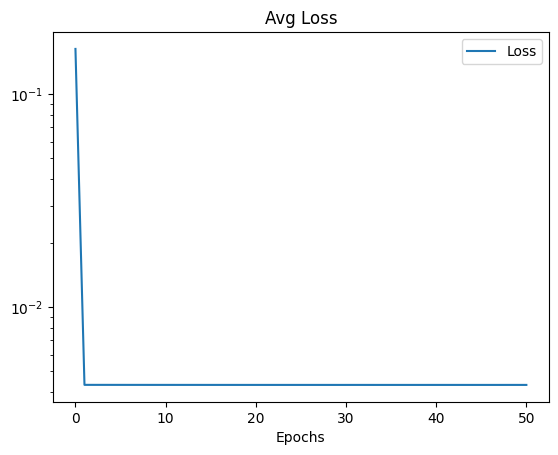

In [12]:
plt.plot(train_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Avg Loss')
plt.show()

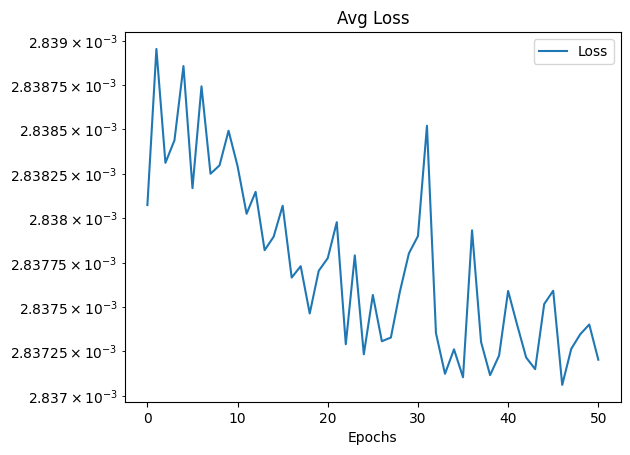

In [13]:
plt.plot(test_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Avg Loss')
plt.show()

In [14]:
def create_csv_with_predictions(model,n_cells, device, input_csv,steps=205):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = nn.MSELoss()
    vrai_pos = []
    norm_acc = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        # print(rot_pos)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells])
        if step%1==0:
            norm_acc.append(np.linalg.norm((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[0]))
            print(loss_fn(acc,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).item())
            loss.append(loss_fn(acc,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).item())
    return loss,norm_acc

In [15]:
loss,acc = create_csv_with_predictions(model,10, device, "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_41.csv",205)

tensor([[-2.5142e-05, -6.9886e-05],
        [-2.3156e-05,  1.5981e-05],
        [-3.5126e-05,  1.3981e-05],
        [-5.7027e-05, -2.6591e-05],
        [-7.1645e-05, -1.4577e-04],
        [-1.1753e-05, -5.4482e-05],
        [ 2.9970e-06,  2.8238e-05],
        [-2.6412e-06,  3.5010e-05],
        [-2.4719e-05,  4.8153e-05],
        [-6.3512e-05,  2.9933e-05]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 5.4964000e-06 -1.4775370e-04]
 [ 2.4519400e-05  5.9499900e-05]
 [-1.4085400e-05  5.3166600e-05]
 [-7.1302800e-05 -6.2937800e-05]
 [-6.9340000e-05 -3.1583280e-04]
 [ 2.0800980e-05 -8.4513200e-05]
 [ 8.3311500e-05  1.2146717e-04]
 [ 9.3753000e-05  1.3319070e-04]
 [-6.1131000e-06  1.5416230e-04]
 [-6.7039800e-05  8.9550600e-05]]
4.739214798377134e-09
tensor([[-1.7164e-05, -9.1106e-05],
        [-1.6678e-05,  1.7095e-05],
        [-3.2047e-05,  1.4246e-05],
        [-5.6308e-05, -3.9894e-05],
        [-7.5880e-05, -1.6120e-04],
        [ 6.8545e-07, -7.4845e-05],
        [ 1.5907e-05,  3.26

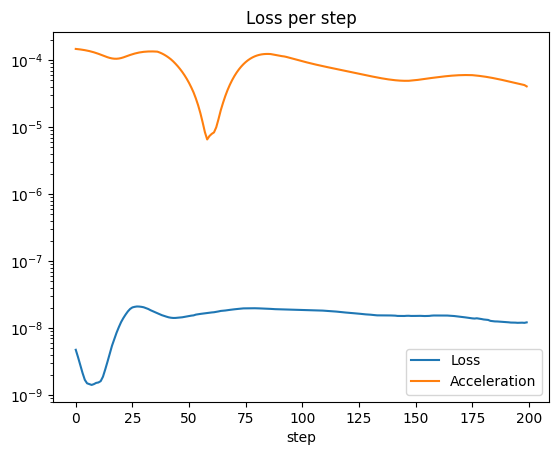

In [16]:
plt.plot(loss, label='Loss')
plt.plot(acc, label='Acceleration')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()

In [17]:
def create_csv_with_real_predictions(model,n_cells, device, input_csv, output_csv, steps=205):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    results = []
    pos = []
    vrai_pos = []
    loss_fn = nn.MSELoss()
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells])
        if step%10==0:
            loss.append(loss_fn(acc,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
        for id_, positions in enumerate(pos[-1]):
                results.append({"step": step, "site_index": id_, "x": positions[0], "y": positions[1]})
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    return loss

In [18]:
loss = create_csv_with_real_predictions(model,10, device, "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_48.csv", "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/positions/computed_positions_48.csv",205)

tensor([[ 3.5476e-05,  6.5677e-06],
        [-6.8806e-05,  6.0201e-05],
        [-3.0698e-05,  6.9655e-05],
        [-9.2484e-05,  1.9945e-05],
        [-7.7777e-05, -1.4158e-04],
        [ 3.7920e-05, -5.1551e-05],
        [-2.5891e-05, -4.9375e-05],
        [-1.9718e-05, -1.6622e-05],
        [-3.1330e-06, -5.1115e-05],
        [-1.7678e-05, -1.5870e-06]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 1.167567e-04  4.502780e-05]
 [-1.120603e-04  2.227420e-04]
 [-1.292060e-05  1.124546e-04]
 [-1.526121e-04  8.953030e-05]
 [-1.245825e-04 -2.559702e-04]
 [ 1.449568e-04 -5.473160e-05]
 [-9.770000e-08 -7.682200e-05]
 [ 3.179800e-05 -2.662860e-05]
 [ 7.472100e-05 -7.375139e-05]
 [ 3.404116e-05  1.814900e-05]]
tensor([[ 4.5687e-05,  8.1770e-06],
        [-7.9421e-05,  7.6294e-05],
        [-3.6918e-05,  8.2940e-05],
        [-1.0896e-04,  3.0331e-05],
        [-8.7669e-05, -1.5982e-04],
        [ 5.3221e-05, -5.9523e-05],
        [-2.2857e-05, -6.1817e-05],
        [-1.5385e-05, -1.9871e-05

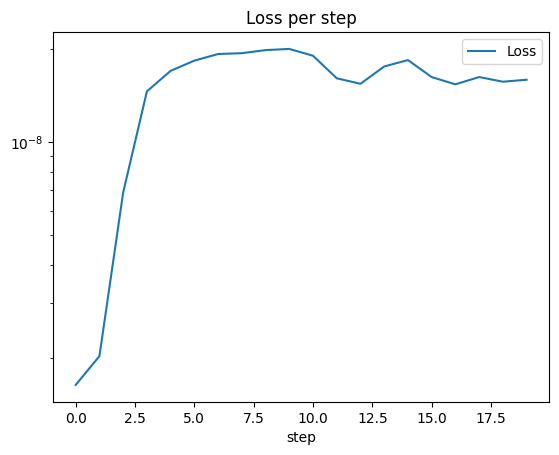

In [19]:
plt.plot(loss, label='Loss')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()